In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
EXTRACTED_FEATURES_DB_NAME = '/data/experiments/YHE/extracted-features/extracted-features.sqlite'

In [3]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query("select * from features", db_conn)
db_conn.close()

In [4]:
sequences_df[['sequence','charge','run_name','number_of_runs_extracted','human','group','classed_as']].sample(n=5)

,sequence,charge,run_name,number_of_runs_extracted,human,group,classed_as
170747,AVDDGVNTFK,2,YHE211_09_Slot1-1_1_3005,30,1,YHE211,target
389894,TYPVQEYFLEDCIQMTHFVPPPK,3,YHE114_06_Slot1-1_1_3013,31,1,YHE114,target
315224,CLCNLVLSSPVAQMLAAEAR,2,YHE010_11_Slot1-1_1_3041,29,1,YHE010,decoy
184469,LPEYTLSQEGGPAHK,3,YHE211_09_Slot1-1_1_3005,24,1,YHE211,target
325544,LLDFTQAQILQGLR,2,YHE010_11_Slot1-1_1_3041,31,1,YHE010,target


In [5]:
sequences_df['group'] = sequences_df.run_name.apply(lambda x: x.split('_')[0])

In [6]:
sequences_df[['sequence','charge','run_name','number_of_runs_extracted','human','group']].sample(n=5)

,sequence,charge,run_name,number_of_runs_extracted,human,group
682387,LGLLESLDLAHQQILDTSGQIK,2,YHE211_07_Slot1-1_1_3003,21,0,YHE211
192121,STAESIVYSALETLAQR,2,YHE211_09_Slot1-1_1_3005,26,0,YHE211
825602,LALSSVDASEQTEWQQLVDDAK,2,YHE114_05_Slot1-1_1_3012,31,1,YHE114
488426,MSANISETTAMITDIATAPAEIDR,3,YHE211_06_Slot1-1_1_3002,23,0,YHE211
259440,CLDPILTIACTLAYR,2,YHE010_05_Slot1-1_1_2990,29,1,YHE010


In [7]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE211') | (sequences_df.group == 'YHE114')]
yhe_only_targets_df = yhe_only_df[(yhe_only_df.classed_as == 'target')]

In [8]:
number_of_yhe_runs_in_experiment = len(yhe_only_df.file_idx.unique())
print('there are {} runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 21 runs in the experiment


#### analyse the rate of successful extractions of peptides in the library

In [9]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.file_idx.unique())))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [10]:
# display the number of missing extractions across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of extractions missing across the experiment.".format(round(proportion_of_missing_extractions*100)))

7.0% of extractions missing across the experiment.


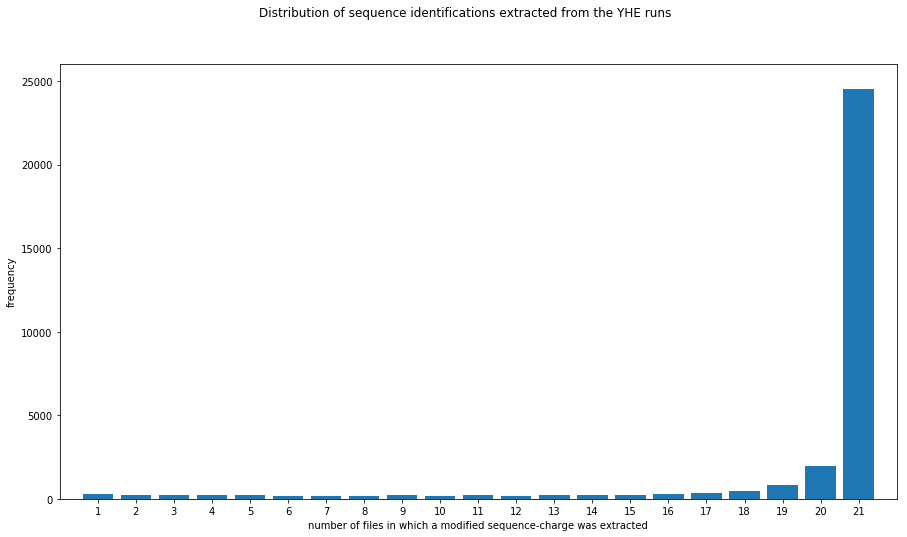

In [11]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications extracted from the YHE runs')
# plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

In [14]:
yhe_only_targets_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_isotope_cv', 'rt_peak_symmetry_0',
       'rt_peak_symmetry_1', 'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_isotope_cv', 'scan_peak

In [15]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in yhe_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1]))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge'])

In [36]:
# display the number of missing values across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values are missing across the YHE-only runs.".format(round(proportion_of_missing_values*100)))

18.0% of values are missing across the YHE-only runs.


In [17]:
yhe_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
23605,SPTAPSVFSPTGNR,2,21,0
26959,VFQSLPHENKPLTLSNYQTNK,2,21,0
1567,APAALPALCDLLASAADPQIR,3,21,0
2712,CNEEHPAYLASDEITTVR,3,8,13
11578,HWPFMVVNDAGRPK,3,21,0
9790,GLQTSQDAR,2,11,10
3602,DGVPEGAQLQGPVHR,2,20,1
5351,EDKPVCDK,2,21,0
24166,SVNNTDATGLIQGVK,2,21,0
7901,FGQAATMEGIGAIGGTPPAFNR,2,21,0


In [18]:
df = yhe_only_df[(yhe_only_df.sequence == 'EHHIDPTAITR') & (yhe_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
5852,EHHIDPTAITR,2,16,target,0.998782
35214,EHHIDPTAITR,2,28,target,0.998985
90264,EHHIDPTAITR,2,23,target,0.749908
144927,EHHIDPTAITR,2,15,target,0.999727
174500,EHHIDPTAITR,2,9,target,0.998874
204060,EHHIDPTAITR,2,25,target,0.946110
233557,EHHIDPTAITR,2,24,target,0.996008
289452,EHHIDPTAITR,2,27,target,0.999569
343170,EHHIDPTAITR,2,20,target,0.871875
371629,EHHIDPTAITR,2,29,target,0.932164


In [19]:
len(yhe_only_df[yhe_only_df.classed_as == 'decoy']) / len(yhe_only_df[yhe_only_df.classed_as == 'target'])

0.19080700123915736

In [23]:
unique_sequences_yhe_df = yhe_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_yhe_df)

31659

In [24]:
unique_sequences_all_runs_df = sequences_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_all_runs_df)

31905

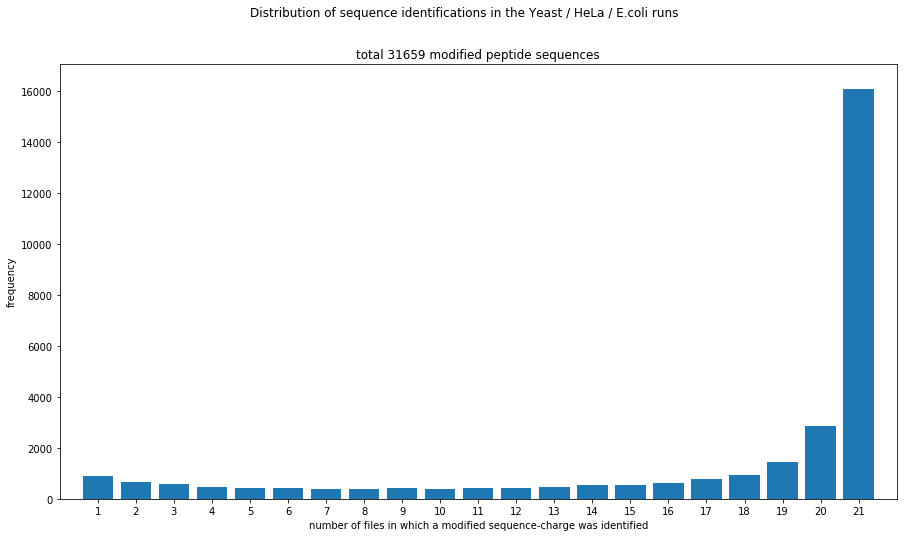

In [37]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the Yeast / HeLa / E.coli runs')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_yhe_df)))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

#### now analyse the human-only runs

In [38]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')]
human_only_targets_df = human_only_df[(human_only_df.classed_as == 'target')]

In [39]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1], group_df.iloc[0].human))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge','human'])


In [40]:
# proportion of false positives i.e. non-human peptides found in the human-only runs
print('false positives: {}%'.format(round(len(human_sequence_occurences_df[(human_sequence_occurences_df.human == 0)]) / len(human_sequence_occurences_df) * 100.0, 1)))

false positives: 11.7%


In [41]:
number_of_human_runs_in_experiment = len(human_only_df.file_idx.unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 human-only runs in the experiment


In [42]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values are missing in the human-only runs.".format(round(proportion_of_missing_values*100)))

23.0% of values are missing in the human-only runs.


In [43]:
human_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
5165,EKPKPTPDYLMQLMNDK,3,9,1
5006,EHLELFWSR,2,10,0
21343,TLAESALQLLYTAK,2,10,0
17725,Q[-17.0265]ALVAIFTHLR,2,10,0
9961,IASLLGLLSK,2,1,9
13195,LLHHDDPEVLADTCWAISYLTDGPNER,3,3,7
1297,APEDAGPQPGSYEIR,2,10,0
9909,IAFADAGDTVEDANFDESNANAAILR,2,9,1
10332,IFYHPETTQLMILSASEATVK,2,9,1
18182,Q[-17.0265]NAEQHVTQLMSTEPLPR,2,10,0


In [44]:
df = human_only_df[(human_only_df.sequence == 'APVAIGVAAMSTAEMLTSGLK') & (human_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
60106,APVAIGVAAMSTAEMLTSGLK,2,4,target,0.999214
115175,APVAIGVAAMSTAEMLTSGLK,2,17,target,0.999445
258615,APVAIGVAAMSTAEMLTSGLK,2,1,target,0.957707
314473,APVAIGVAAMSTAEMLTSGLK,2,6,target,0.989224
394816,APVAIGVAAMSTAEMLTSGLK,2,12,target,0.980972
421445,APVAIGVAAMSTAEMLTSGLK,2,3,target,0.951320
447007,APVAIGVAAMSTAEMLTSGLK,2,2,decoy,0.476260
560275,APVAIGVAAMSTAEMLTSGLK,2,5,target,0.981317
613658,APVAIGVAAMSTAEMLTSGLK,2,19,target,0.999955
698555,APVAIGVAAMSTAEMLTSGLK,2,7,target,0.991500


In [45]:
len(df)

10

In [48]:
unique_sequences_human_only_df = human_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_human_only_df)

28814

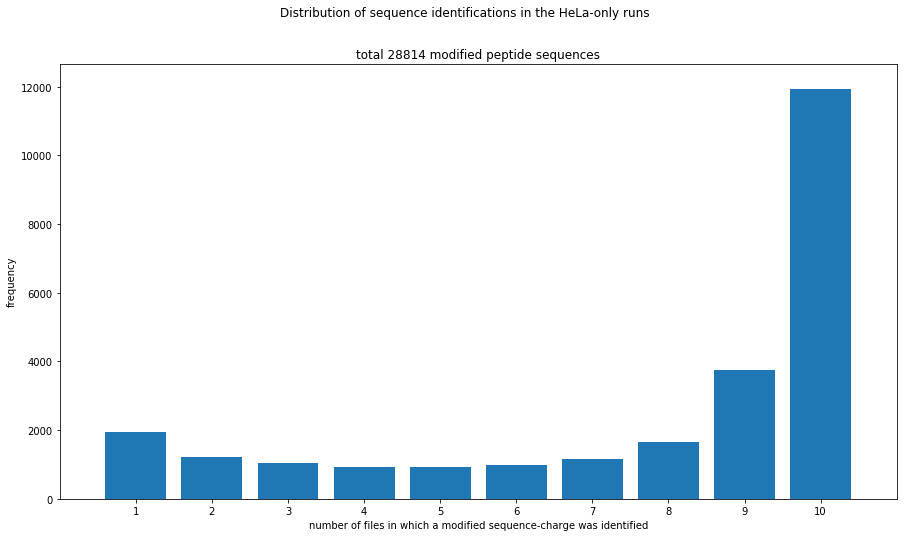

In [49]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
# plt.ylim((0,20000))

plt.show()